In [1]:
pip install einops ftfy vector_quantize_pytorch ipywidgets torch torchvision packaging pytorch-warmup ema-pytorch accelerate tqdm matplotlib setuptools pillow resize_right x_clip rotary_embedding_torch coca_pytorch webdataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install --upgrade setuptools==58.0.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.5/816.5 kB 9.8 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 70.0.0
    Uninstalling setuptools-70.0.0:
      Successfully uninstalled setuptools-70.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.20.0 requires setuptools>=60.0.0, but you have setuptools 58.0.4 which is incompatible.
conda 24.9.0 requires packaging>=23.0, but you have packaging 21.3 which is incompatible.
conda 24.9.0 requires setuptools>=60.0.0, but you have setuptools 58.0.4 which is incompatible.
jupyterlab 4.2.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [3]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x4142l2s
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x4142l2s
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369529 sha256=eb761a0c023e24f652bd2604bbf587dcaafc07921dda1d1de244880202f26a55
  Stored in directory: /tmp/pip-ephem-wheel-cache-u2xz6x2z/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [4]:
import sys
import os


sys.path.append('/kaggle/input/codefor53/DALLE2-pytorch-main/dalle2_pytorch')


In [5]:
import torch
import os
import clip
from pathlib import Path
from typing import List, Dict
from accelerate import Accelerator
from tqdm import tqdm  # tqdm for progress bar
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
# Adjusted import for tokenizer and other modules
from tokenizer import SimpleTokenizer  # Update import for tokenizer
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior,  Unet, Decoder, OpenAIClipAdapter, CLIP
from trainer import  DiffusionPriorTrainer , DecoderTrainer 
from torchvision.utils import make_grid, save_image
from PIL import Image
from datetime import datetime
import json
from torchvision import transforms
import torch.utils.data as data
import torchvision.transforms as T
from dataloaders.prior_loader import make_splits, get_reader, PriorEmbeddingDataset
from dataloaders.decoder_loader import ImageEmbeddingDataset, create_image_embedding_dataloader
from sklearn.decomposition import PCA
import numpy as np
import torch.nn as nn

/opt/conda/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [6]:
!mkdir -p /kaggle/working/tar_file

In [7]:
import tarfile
# Define the name of the archive
tar_filename = '00000.tar'

# Define the folder or files you want to compress
folder_to_compress = '/kaggle/input/75-dataset/new_75_dataset/images_and_texts'

# Open a tarfile in write mode
with tarfile.open(tar_filename, 'w') as tar:
    # Add the folder or files to the tar file
    tar.add(folder_to_compress, arcname='')

print(f'{tar_filename} created successfully')

00000.tar created successfully


In [8]:
# Define the preprocessing to convert images to PyTorch tensors
img_preproc = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to PyTorch tensor
    # Add other transformations if necessary (e.g., resizing, normalization)
])
import torch
import matplotlib.pyplot as plt

def show_image_tensor_batch(image_tensor):
    # Move the tensor to CPU and convert to NumPy
    image_np = image_tensor.cpu().numpy()
    
    # Change the shape from (B, C, H, W) to (B, H, W, C)
    image_np = image_np.transpose(0, 2, 3, 1)
    
    # Normalize the pixel values if needed
    image_np = (image_np * 255).astype(np.uint8)
    
    # Set up the figure
    fig, axes = plt.subplots(1, image_np.shape[0], figsize=(10, 5))
    
    for i in range(image_np.shape[0]):
        axes[i].imshow(image_np[i])
        axes[i].axis('off')  # Hide axes

    plt.show()







# Create a dataloader directly.
dataloader = create_image_embedding_dataloader(
    tar_url="/kaggle/working/00000.tar", # Uses bracket expanding notation. This specifies to read all tars from 0000.tar to 9999.tar
    img_embeddings_url="/kaggle/input/75-dataset/new_75_dataset/embeddings_folder_image/img_emb",
    text_embeddings_url="/kaggle/input/75-dataset/new_75_dataset/embeddings_folder_text/text_emb",
    num_workers=1,
    batch_size=1,
    index_width=4,                                         # If a file in the webdataset shard 3 is named 0003039.jpg, we know the shard width is 4 and the last three digits are the index
    shuffle_num=200,                                       # Does a shuffle of the data with a buffer size of 200
    shuffle_shards=True,                                   # Shuffle the order the shards are read in
    resample_shards=False,                                 # Sample shards with replacement. If true, an epoch will be infinite unless stopped manually
    img_preproc=img_preproc,  # Pass the preprocessing step
)

print((dataloader))

for img, emb_dict, emb, additional in dataloader:  # Adjust according to the number of items
    img_embeddings = emb_dict['img']  # Extract the image embeddings
    text_embeddings = emb_dict['text']  # Extract the text embeddings

#     show_image_tensor_batch(img)

    print("Image tensor shape:", img.shape)             # Shape of the image tensor
    print("Image embeddings shape:", img_embeddings.shape)  # Shape of the image embeddings
    print("Text embeddings shape:", text_embeddings.shape)  # Shape of the text embeddings
    print("Additional tensor shape:", additional.shape)    # Handle additional items if needed

    


# Or create a dataset without a loader so you can configure it manually
dataset = ImageEmbeddingDataset(
    urls="/kaggle/working/00000.tar",
    img_embedding_folder_url="/kaggle/input/75-dataset/new_75_dataset/embeddings_folder_image/img_emb",
    text_embedding_folder_url="/kaggle/input/75-dataset/new_75_dataset/embeddings_folder_text/text_emb",
    index_width=4,
    shuffle_shards=True,
    resample=False
)





def create_dataloaders(
        dataset=dataset,
        batch_size=1,
        num_workers=1,
        train_prop=0.75,
        val_prop=0.15,
        test_prop=0.10,
        img_preproc=None,
        seed=0,
        **kwargs
):
    assert train_prop + val_prop + test_prop == 1, "Train, val, and test proportions must sum to 1."




    # Define image transformations
    transform = img_preproc if img_preproc is not None else transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

 

    # Randomly split dataset
    num_samples = 50
    indices = list(range(num_samples))
    np.random.seed(seed)
    np.random.shuffle(indices)

    train_end = int(train_prop * num_samples)
    val_end = train_end + int(val_prop * num_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]



    train_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    val_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)
    test_dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

    print(f"Number of samples in dataset: {num_samples}")
    print(f"Training samples: {len(train_indices)}")
    print(f"Validation samples: {len(val_indices)}")
    print(f"Test samples: {len(test_indices)}")


    return {
        "train": train_dataloader,
        "val": val_dataloader,
        "test": test_dataloader
    }



dataloaders = create_dataloaders (
    dataset,
    img_preproc=None,
    train_prop = 1,
    val_prop = 0,
    test_prop = 0,
    n_sample_images=10,

    
)


Image tensor shape: torch.Size([1, 3, 256, 256])
Image embeddings shape: torch.Size([1, 512])
Text embeddings shape: torch.Size([1, 512])
Additional tensor shape: torch.Size([1, 512])
Image tensor shape: torch.Size([1, 3, 256, 256])
Image embeddings shape: torch.Size([1, 512])
Text embeddings shape: torch.Size([1, 512])
Additional tensor shape: torch.Size([1, 512])
Image tensor shape: torch.Size([1, 3, 256, 256])
Image embeddings shape: torch.Size([1, 512])
Text embeddings shape: torch.Size([1, 512])
Additional tensor shape: torch.Size([1, 512])
Image tensor shape: torch.Size([1, 3, 256, 256])
Image embeddings shape: torch.Size([1, 512])
Text embeddings shape: torch.Size([1, 512])
Additional tensor shape: torch.Size([1, 512])
Image tensor shape: torch.Size([1, 3, 256, 256])
Image embeddings shape: torch.Size([1, 512])
Text embeddings shape: torch.Size([1, 512])
Additional tensor shape: torch.Size([1, 512])
Image tensor shape: torch.Size([1, 3, 256, 256])
Image embeddings shape: torch.S

In [9]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import CLIPTokenizer  # Use a tokenizer suitable for CLIP, if available


class ImageTextDataset(Dataset):
    def __init__(self, img_dir, txt_dir, transform=None, tokenizer=None, max_text_len=256):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_text_len = max_text_len

        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])
        self.text_files = sorted([f.replace('.jpg', '.txt').replace('.png', '.txt') for f in self.image_files])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        txt_path = os.path.join(self.txt_dir, self.text_files[idx])
        with open(txt_path, 'r') as f:
            text = f.read().strip()

        if self.tokenizer:
            text_tokens = self.tokenizer(text, max_length=self.max_text_len, truncation=True, padding='max_length', return_tensors='pt')['input_ids'].squeeze(0)
        else:
            text_tokens = torch.randint(0, 49408, (self.max_text_len,))
        
        return image, text, text_tokens

# Define paths to image and text directories
img_dir = '/kaggle/input/75-dataset/new_75_dataset/images_and_texts'
txt_dir = '/kaggle/input/75-dataset/new_75_dataset/75_texts'

# Optionally, define a tokenizer (e.g., CLIP tokenizer)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create dataset and dataloader
dataset = ImageTextDataset(
    img_dir=img_dir,
    txt_dir=txt_dir,
    transform=image_transform,
    tokenizer=tokenizer  # Assuming no tokenizer, displaying raw captions
)

dataloader_2 = DataLoader(dataset, batch_size=1, shuffle=True)


for img_batch, caption_batch, _ in dataloader_2:
    print("Image batch shape:", img_batch.shape)  # Should be [batch_size, 3, 256, 256]
    
    # Print the list of captions instead of shape
    print("Captions:", caption_batch)  # Display the list of captions
    
    
# Function to plot images and display captions
def plot_images_with_captions(images, captions):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, (image, caption) in enumerate(zip(images, captions)):
        axes[idx].imshow(image.permute(1, 2, 0))
        axes[idx].set_title(caption)
        axes[idx].axis('off')
    plt.show()

# Iterate over the dataloader and plot images with captions
for img_batch, caption_batch, _ in dataloader_2:
    
    # Denormalize images for correct visualization
    img_batch = img_batch * 0.5 + 0.5  # Undo normalization to bring back [0, 1] range
    
#     Plot images with captions
#     plot_images_with_captions(img_batch, caption_batch)
   


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('A bear is sniffing a trainer in an enclosure.',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('there is a cat sitting in a small cooler',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('A plate with meat, pasta, and veggies, is ready to be eaten.',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('A man in a chair using a laptop while holding a cat.',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('An orange flatbed truck parked in front of a chocolate store.',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('A man wearing a black shirt is dancing in front of an object.',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('A cat sitting next to an apple computer, on the keyboard.',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: ('some people sitting on a bench outside of a donut shop',)
Image batch shape: torch.Size([1, 3, 256, 256])
Captions: 

In [10]:
# Training Loop Parameters

batch_size = 1    # Using batch size of 4
t=SimpleTokenizer()


clip = CLIP(
    dim_text = 256,
    dim_image = 256,
    dim_latent = 256,
    num_text_tokens = 49408,
    text_enc_depth = 8,
    text_seq_len = 256,
    text_heads = 8,
    visual_enc_depth = 8,
    visual_image_size = 256,
    visual_patch_size = 64,
    visual_heads = 8
).cuda()


# prior networks (with transformer)

prior_network = DiffusionPriorNetwork(
    dim = 256,
    depth = 8,
    dim_head = 64,
    heads = 8
).cuda()

diffusion_prior = DiffusionPrior(
    net = prior_network,
    clip = clip,
    timesteps = 1000,
    beta_schedule = "cosine",
    cond_drop_prob = 0.1
).cuda()


diffusion_prior_trainer = DiffusionPriorTrainer(
    diffusion_prior,
    lr = 5e-4,
    wd = 1e-2,
    ema_beta = 0.9,
    ema_update_after_step = 100,
    ema_update_every = 20,
)




num_epochs=100


for epoch in tqdm(range(num_epochs)):
    # for prior_batch_idx, (img, emb_dict, emb, additional) in enumerate(dataloader):
    for (img, emb_dict, emb, additional), (images_2, texts_2,text_tokens) in zip(dataloader, dataloader_2):
        
        
               # Tokenize the text and move to GPU
        tokenized_text = t.tokenize(texts_2).cuda()  # Wrap the string in a list for tokenization
  
        
        img_embeddings = emb_dict['img']  # Extract the image embeddings
        text_embeddings = emb_dict['text']  # Extract the text embeddings
        img_embeddings=img_embeddings.float()
        text_embeddings=text_embeddings.long()
        loss = diffusion_prior_trainer(
            image=img.cuda(),
#             image_embed=img_embeddings.cuda(),
            text=tokenized_text,
            max_batch_size=1
        )
        diffusion_prior_trainer.update()




    



unet1 = Unet(
    dim = 64,
    image_embed_dim = 256,
    text_embed_dim = 256,
    cond_dim = 256,
    channels = 3,
    dim_mults=(1, 2, 4, 8),
    cond_on_text_encodings = True ,   # set to True for any unets that need to be conditioned on text encodings
    cond_on_image_embeds = True ,
    channels_out = 3
).cuda()



decoder = Decoder(
    unet = unet1,
    image_size =  256,
    clip = clip,
    timesteps = 1000,
#     beta_schedule = "cosine",
    image_cond_drop_prob = 0.1,
    text_cond_drop_prob = 0.1
).cuda()

# Initialize an Accelerator object
accelerator = Accelerator()
decoder_trainer = DecoderTrainer(
    decoder=decoder,
    accelerator=accelerator,  # Pass the `Accelerator` object here
    dataloaders=dataloaders,
    lr = 5e-4,
    wd = 1e-2,
    ema_beta = 0.9,
    ema_update_after_step = 100,
    ema_update_every = 20,
)


input_dim = 512
output_dim = 256

# Create the linear layer
linear_layer = nn.Linear(input_dim, output_dim)


for epoch in tqdm(range(num_epochs)):
    # for prior_batch_idx, (img, emb_dict, emb, additional) in enumerate(dataloader):
    for (img, emb_dict, emb, additional), (images_2, texts_2,text_tokens) in zip(dataloader, dataloader_2):
        
       
               # Tokenize the text and move to GPU
        tokenized_text = t.tokenize(texts_2).cuda()  # Wrap the string in a list for tokenization

            
        img_embeddings = emb_dict['img']  # Extract the image embeddings
        text_embeddings = emb_dict['text']  # Extract the text embeddings
        
        img_embeddings=img_embeddings.float()
        projected_embeddings = linear_layer(img_embeddings)
        
        text_embeddings=text_embeddings.long()
 
        loss = decoder_trainer(
            image=img.cuda(),
            image_embed=projected_embeddings.cuda(),
            text =tokenized_text,
            unet_number=1,
            max_batch_size=1
        )
        decoder_trainer.update(1)
        
        
#     dalle2 = DALLE2(
#     prior = diffusion_prior,
#     decoder = decoder
#     )
#     gen_images = dalle2(
#     ['Laptop on table'],
#     cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
#     ).cuda()


#     save_image(gen_images, 'image.png')

#     for img in gen_images:
#         img = ToPILImage()(img)
#         img.show()


#     from matplotlib import pyplot as plt

#     # Visualize image using matplotlib instead of Jupyter widgets
#     for img in gen_images:
#         img_pil = ToPILImage()(img)  # Convert tensor to PIL image
#         plt.imshow(img_pil)
#         plt.axis('off')
#         plt.show()  # Show image without using Jupyter's widget

    
        





# do above for many steps

dalle2 = DALLE2(
    prior = diffusion_prior,
    decoder = decoder
)



100%|██████████| 100/100 [44:21<00:00, 26.62s/it]


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen_images = dalle2(
    ['Laptop on Table'],
    cond_scale = 2. # classifier free guidance strength (> 1 would strengthen the condition)
).cuda()

print(gen_images.shape)



save_image(gen_images, 'image.png')

for img in gen_images:
    img = ToPILImage()(img)
    img.show()

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 3, 256, 256])


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpuddmu6dy.PNG'


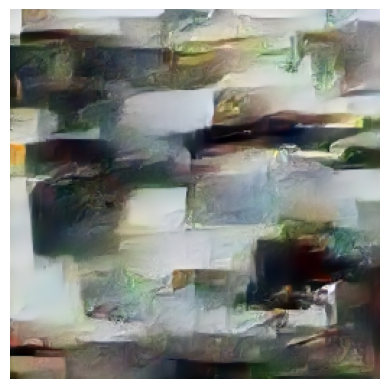

In [12]:
from matplotlib import pyplot as plt

# Visualize image using matplotlib instead of Jupyter widgets
for img in gen_images:
    img_pil = ToPILImage()(img)  # Convert tensor to PIL image
    plt.imshow(img_pil)
    plt.axis('off')
    plt.show()  # Show image without using Jupyter's widget
